In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pprint
import pandas as pd
import tqdm
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import TensorBoard

2024-02-02 12:43:11.922579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 12:43:12.083222: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 12:43:12.702936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:/raid/home/labuserdia/.conda/envs/DLexp/lib/
2024-02-02 12:43:12.703026: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'

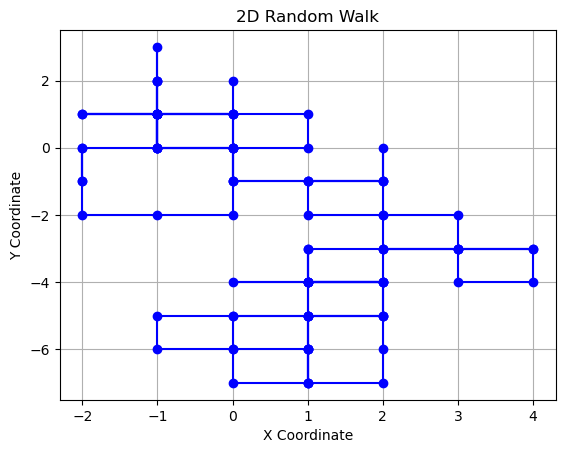

In [2]:
def generate_2d_random_walk(num_steps, step_size=1):
    # Initialize the position at the origin
    current_position = np.array([0, 0])

    # Arrays to store the x and y coordinates of the random walk
    x_coordinates = [current_position[0]]
    y_coordinates = [current_position[1]]

    # Define possible moves: up, down, left, right
    moves = np.array([[0, 1], [0, -1], [-1, 0], [1, 0]])

    # Generate the random walk
    for _ in range(num_steps):
        # Randomly choose a move
        move = moves[np.random.choice(len(moves))]

        # Update the current position
        current_position += step_size * move

        # Append the new coordinates to the lists
        x_coordinates.append(current_position[0])
        y_coordinates.append(current_position[1])

    return x_coordinates, y_coordinates

# Example: Generate a random walk with 100 steps
num_steps = 100
x_walk, y_walk = generate_2d_random_walk(num_steps)

# Plot the random walk
plt.plot(x_walk, y_walk, marker='o', linestyle='-', color='b')
plt.title("2D Random Walk")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

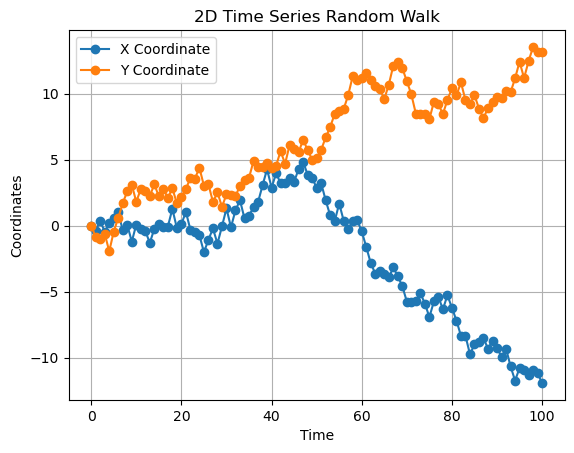

In [3]:
def generate_2d_time_series_random_walk(num_steps, max_step_length=1.5, time_interval=1):
    # Initialize the position at the origin
    current_position = np.array([0.0, 0.0])

    # Lists to store the time, x, and y coordinates of the time series random walk
    time_stamps = [0]
    x_coordinates = [current_position[0]]
    y_coordinates = [current_position[1]]

    # Generate the time series random walk
    for step in range(1, num_steps + 1):
        # Generate a random move within the maximum step length constraint
        move = np.random.uniform(-max_step_length, max_step_length, size=2)

        # Update the current position
        current_position += move

        # Append the new coordinates and timestamp to the lists
        x_coordinates.append(current_position[0])
        y_coordinates.append(current_position[1])
        time_stamps.append(step * time_interval)

    # Create a DataFrame to store the time series data
    time_series_data = pd.DataFrame({
        'Time': time_stamps,
        'X Coordinate': x_coordinates,
        'Y Coordinate': y_coordinates
    })

    return time_series_data

# Example: Generate a 2D time series random walk with 100 steps
num_steps = 100
time_series_data = generate_2d_time_series_random_walk(num_steps)

# Plot the time series random walk
plt.plot(time_series_data['Time'], time_series_data['X Coordinate'], label='X Coordinate', marker='o')
plt.plot(time_series_data['Time'], time_series_data['Y Coordinate'], label='Y Coordinate', marker='o')
plt.title("2D Time Series Random Walk")
plt.xlabel("Time")
plt.ylabel("Coordinates")
plt.legend()
plt.grid(True)
plt.show()

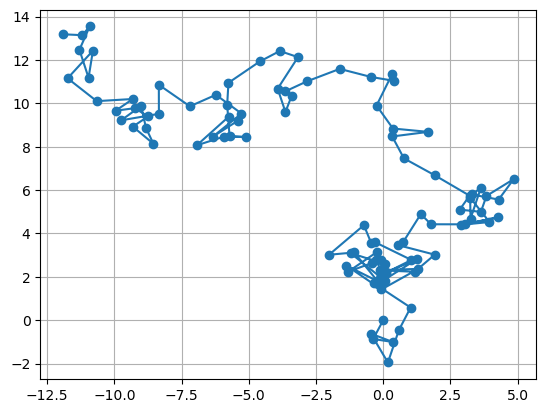

In [4]:
plt.plot(time_series_data['X Coordinate'], time_series_data['Y Coordinate'], marker='o')
plt.grid()
plt.show()

/tmp/ipykernel_1539018/2947257410.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('viridis'),


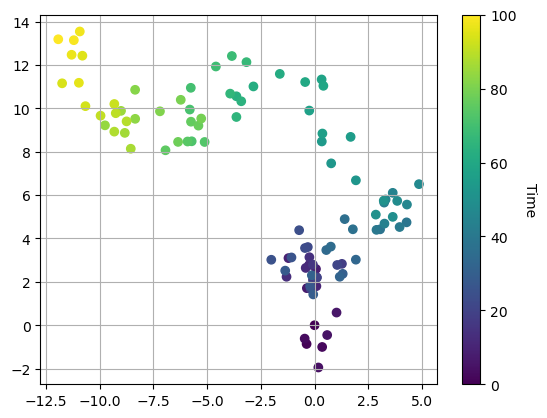

In [5]:
fig, ax = plt.subplots()
scatter = ax.scatter(
    time_series_data['X Coordinate'],
    time_series_data['Y Coordinate'],
    c=time_series_data['Time'],
    marker='o',
    cmap=plt.cm.get_cmap('viridis'),
)

cbar = plt.colorbar(scatter, ax=ax, label='Time')
cbar.set_label('Time', rotation=270, labelpad=15)

plt.grid(True)
plt.show()

In [6]:
def generate_target_variable(time_series_data):
    # Extract X and Y coordinates from the time series data
    x_coordinates = time_series_data['X Coordinate'].values
    y_coordinates = time_series_data['Y Coordinate'].values

    # Calculate the Euclidean distance from the origin (0,0)
    euclidean_distance = np.sqrt(x_coordinates**2 + y_coordinates**2)

    # Create a DataFrame to store the target variable
    target_data = pd.DataFrame({
        'Time': time_series_data['Time'],
        'Target': euclidean_distance
    })

    return target_data

dataset = generate_2d_time_series_random_walk(15000, max_step_length=1.5, time_interval=1).values
dataset = dataset.astype('float32')
dataset = dataset[:,1:3]
#Y_train = generate_target_variable(X_train)

In [ ]:
print(dataset[0:10])

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

10500 4501


In [ ]:
train[1]

In [9]:
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0:2]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0:2])
        
    return np.array(dataX), np.array(dataY)

In [10]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(f"Size of training set : {trainX.shape, trainY.shape}")
print(f"Size of test set : {testX.shape, testY.shape}")

Size of training set : ((10498, 1, 2), (10498, 2))
Size of test set : ((4499, 1, 2), (4499, 2))


In [11]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[2]))

In [21]:
testX.shape

(4499, 1, 2)

In [12]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [13]:
tfd = tfp.distributions
input_shape = trainX.shape[-1]
tf.keras.backend.set_floatx('float32')


input1 = layers.Input(shape=(1, look_back))
x1 = layers.LSTM(32, return_sequences=True)(input1)
x1 = tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False)(x1)
x1 = tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/trainX.shape[0])(x1)
y1 = tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))(x1)

# input2 = layers.Input(shape=(1, look_back))
# x2 = layers.LSTM(32, return_sequences=True)(input2)
# x2 = tfp.layers.DenseFlipout(32, activation='relu')(x2)
# x2 = tfp.layers.DenseFlipout(16, activation='relu')(x2)
# y2 = tfp.layers.DenseFlipout(1, activation='relu')(x2)

input2 = layers.Input(shape=(1, look_back))
x2 = layers.LSTM(32, return_sequences=True)(input2)
x2 = tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False)(x2)
x2 = tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/trainX.shape[0])(x2)
y2 = tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))(x2)

model = keras.Model(inputs=[input1,input2], outputs=[y1,y2])

# model = tf.keras.Sequential([
#     layers.Input(shape=(input_shape,)),  # Adjust 'input_shape' based on your data
#     layers.LSTM(32, return_sequences=True),
#     tfp.layers.DenseFlipout(32, activation='relu'),  # Flipout is a Bayesian layer
#     tfp.layers.DenseFlipout(16, activation='relu'),
#     tfp.layers.DenseFlipout(2)  # Output layer for a double value prediction
# ])

# Define the likelihood function
#loss = tfp.experimental.nn.losses.negloglik()

# Compile the model
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mse')

2024-02-02 12:43:52.587820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 12:43:54.882191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30901 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2024-02-02 12:43:54.884854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30901 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:0b:00.0, compute capability: 7.0


In [ ]:
#!rm -rf ./logs/

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True)

BOARD = TensorBoard(log_dir='logs/fit/{}'.format('Bayesian_reg2'))

history = model.fit(
    x=[trainX[:,:,0],trainX[:,:,1]],
    y=[trainY[:,0],trainY[:,1]],
    batch_size=64,
    epochs=50,
    validation_split=0.3,
    callbacks=[early_stopping, BOARD])

Layer DenseVariational has arguments ['units', 'make_posterior_fn', 'make_prior_fn', 'kl_weight', 'kl_use_exact', 'activation', 'use_bias', 'activity_regularizer']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/50


2024-02-02 12:44:49.768683: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


115/115 [==============================] - 9s 21ms/step - loss: 2.4821 - distribution_lambda_loss: 1.3472 - distribution_lambda_1_loss: 1.1348 - val_loss: 1.8016 - val_distribution_lambda_loss: 0.8152 - val_distribution_lambda_1_loss: 0.9863
Epoch 2/50
115/115 [==============================] - 1s 9ms/step - loss: 1.7313 - distribution_lambda_loss: 0.9224 - distribution_lambda_1_loss: 0.8088 - val_loss: 1.3968 - val_distribution_lambda_loss: 0.7905 - val_distribution_lambda_1_loss: 0.6061
Epoch 3/50
115/115 [==============================] - 1s 10ms/step - loss: 1.3811 - distribution_lambda_loss: 0.7335 - distribution_lambda_1_loss: 0.6474 - val_loss: 1.2997 - val_distribution_lambda_loss: 0.6701 - val_distribution_lambda_1_loss: 0.6294
Epoch 4/50
115/115 [==============================] - 1s 9ms/step - loss: 1.2571 - distribution_lambda_loss: 0.6621 - distribution_lambda_1_loss: 0.5947 - val_loss: 1.1784 - val_distribution_lambda_loss: 0.6027 - val_distribution_lambda_1_loss: 0.5754
E

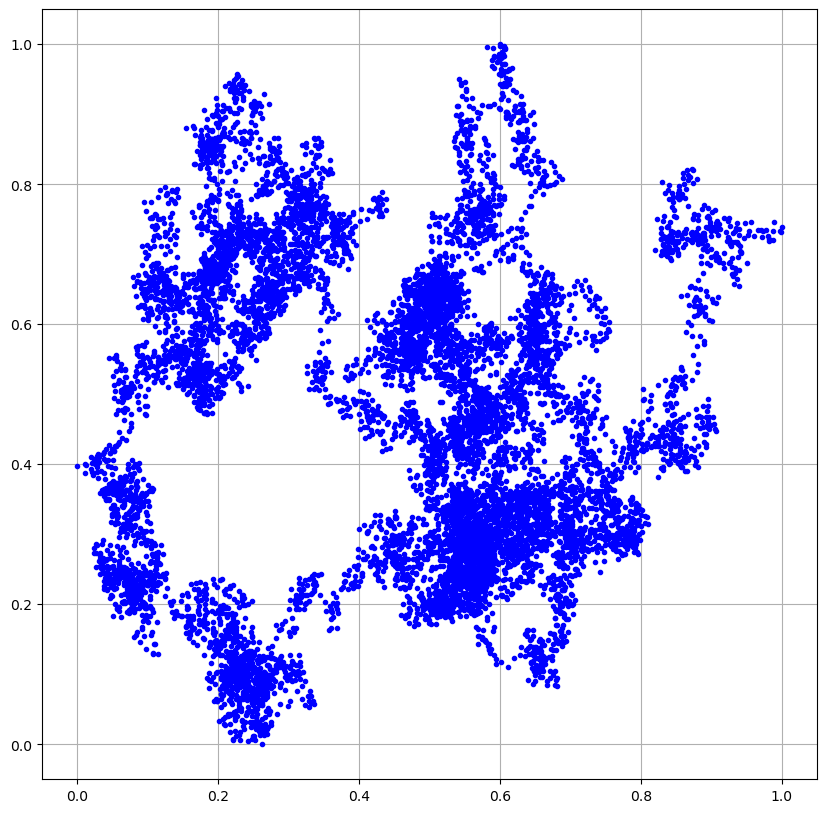

In [18]:
plt.figure(figsize=[10, 10])  # inches
plt.plot(trainX[:,:,0], trainX[:,:,1], 'b.', label='observed')
plt.plot(yhat)
plt.grid()
plt.show()

In [41]:
yhats = model([testX[:,:,0],testX[:,:,1]])
print(yhats[0])
# plt.figure(figsize=[10, 10])  # inches
# plt.plot(trainX[:,:,0], trainX[:,:,1], 'b.', label='observed')
# plt.plot(yhat)
# plt.grid()
# plt.show()

tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[4499, 1, 1], event_shape=[], dtype=float32)


In [102]:
prediction = [model([testX[:,:,0],testX[:,:,1]]) for _ in range(3)]
#print(prediction[0])
# avgmx = np.zeros_like(testX[:,:,0][..., 0])
# for i, prediction[:][:][0] in enumerate(prediction[:][:][:,0].numpy()):
#     m = np.squeeze(prediction[:][:][:,0].numpy().mean())
#     s = np.squeeze(prediction[:][:][:,0].numpy().stddev())
#     if i < 8:
#         plt.plot(testX[:,:,0], m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
#         plt.plot(testX[:,:,0], m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
#         plt.plot(testX[:,:,0], m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
#     avgm += m
# plt.plot(testX[:,:,0], avgm/len(yhats), 'r', label='overall mean', linewidth=4)

# means = [distribution[0].mean().numpy().reshape(-1) for distribution in prediction]

# plt.plot(means[0], label='Prediction 1')  # Plot the first prediction
# plt.plot(means[1], label='Prediction 2')  # Plot the second prediction
# plt.legend()
# plt.show()

# plt.plot(range(len(testX[:,:,0])), testX[:,:,0], 'b.', label='observed')
# for k in range(10):
    
#     ensemble_means = [distribution[i].mean().numpy().reshape(-1) for distribution in prediction]
#     ensemble_stds = [distribution[i].stddev().numpy().reshape(-1) for distribution in prediction]

#     # Calculate ensemble mean (average of individual means)
#     ensemble_mean = sum(ensemble_means) / len(ensemble_means)

#     # Calculate overall mean (mean of all prediction values)
#     all_predictions = np.concatenate(ensemble_means)
#     overall_mean = all_predictions.mean()

#     # Calculate upper bound (ensemble mean + 2 standard deviations)
#     upper_bound = ensemble_mean + 2 * np.mean(ensemble_stds)
#     lower_bound = ensemble_mean - 2 * np.mean(ensemble_stds)

#     # Plot the results
#     plt.plot(ensemble_mean, label='Ensemble Mean')
#     plt.plot(upper_bound, label='Ensemble Mean + 2 SD')
#     plt.plot(lower_bound, label='Ensemble Mean - 2 SD')
#     plt.axhline(y=overall_mean, color='red', linestyle='--', label='Overall Mean')

#     # Customize plot appearance (optional)
#     plt.fill_between(range(4499), ensemble_mean, upper_bound, alpha=0.2, color='lightblue')
#     plt.fill_between(range(4499), ensemble_mean, lower_bound, alpha=0.2, color='lightblue')
#     plt.xlabel('Data Points')
#     plt.ylabel('Predicted Value')
#     plt.title('Ensemble Predictions with Uncertainty')
#     plt.legend()
#     plt.show()

# ensemble_means = []
# ensemble_stds = []
# for single_prediction in prediction:
#     means = [distribution.mean().numpy().reshape(-1) for distribution in single_prediction]
#     stds = [distribution.stddev().numpy().reshape(-1) for distribution in single_prediction]
#     ensemble_means.append(means)
#     ensemble_stds.append(stds)

# # Calculate ensemble mean and overall mean
# ensemble_mean = np.mean(ensemble_means, axis=0)  # Average across predictions
# overall_mean = ensemble_mean.mean()  # Average across all values

# # Calculate upper bound
# upper_bound = ensemble_mean + 2 * np.mean(ensemble_stds, axis=0)

# # Plot the results
# plt.plot(ensemble_mean, label='Ensemble Mean')
# plt.plot(upper_bound, label='Ensemble Mean + 2 SD')
# plt.axhline(y=overall_mean, color='red', linestyle='--', label='Overall Mean')

# # Customize plot appearance (optional)
# #plt.fill_between(range(4499), ensemble_mean, upper_bound, alpha=0.2, color='lightblue')
# plt.xlabel('Data Points')
# plt.ylabel('Predicted Value')
# plt.title('Ensemble Predictions with Uncertainty (10 Predictions)')
# plt.legend()
# plt.show()

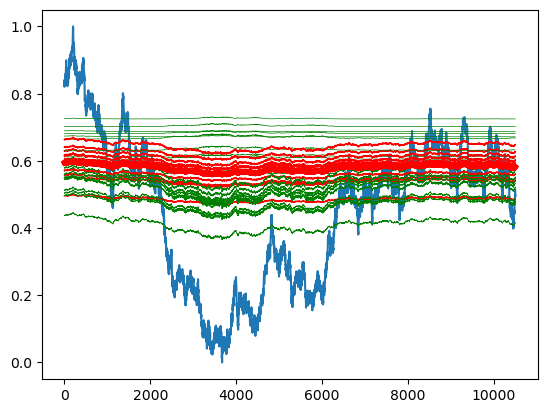

In [117]:
x_tstx, x_tsty = trainX[:,:,0], trainX[:,:,1]
yhats = [model([x_tstx, x_tstx]) for _ in range(10)]

avgm1 = np.zeros_like(x_tstx[..., 0])
avgm2 = np.zeros_like(x_tsty[..., 0])

plt.plot(range(len(x_tstx)),x_tstx,label='observed')

for i, yhat in enumerate(yhats):
    m1, m2 = yhat[0].mean(), yhat[1].mean()  # Extract means for both distributions
    s1, s2 = yhat[0].stddev(), yhat[1].stddev()  # Extract standard deviations for both distributions

    if i < 15:
        plt.plot(range(len(x_tstx)), m1[:,:,0], 'r', label='ensemble mean 1' if i == 0 else None, linewidth=1.)
        plt.plot(range(len(x_tstx)), m1[:,:,0] + 2 * s1[:,:,0], 'g', linewidth=0.5, label='ensemble mean 1 + 2 stdev' if i == 0 else None)
        plt.plot(range(len(x_tstx)), m1[:,:,0] - 2 * s1[:,:,0], 'g', linewidth=0.5, label='ensemble mean 1 - 2 stdev' if i == 0 else None)

        # plt.plot(x_tsty, m2, 'b', label='ensemble mean 2' if i == 0 else None, linewidth=1.)
        # plt.plot(x_tsty, m2 + 2 * s2, 'c', linewidth=0.5, label='ensemble mean 2 + 2 stdev' if i == 0 else None)
        # plt.plot(x_tsty, m2- 2 * s2, 'c', linewidth=0.5, label='ensemble mean 2 - 2 stdev' if i == 0 else None)

    avgm1 += m1[:,:,0]
    #avgm2 += m2[:,:,0]

plt.plot(range(len(x_tstx)), avgm1[:,0] / len(yhats), 'r', label='overall mean 1', linewidth=4)
#plt.plot(x_tsty, avgm2 / len(yhats), 'b', label='overall mean 2', linewidth=4)

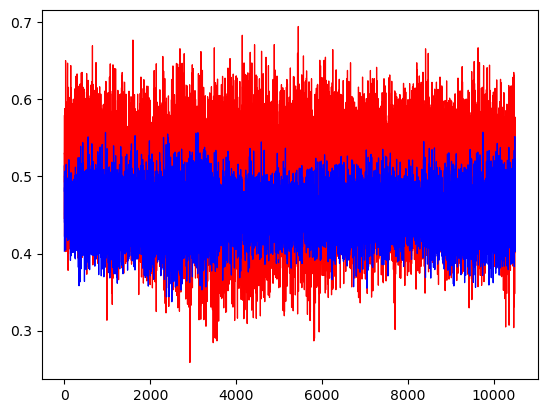

In [120]:
num_samples = 2

for i in range(num_samples):
    yhat_list = model([x_tstx, x_tsty])  # Get predictions for each sample
    sample1 = yhat_list[0].sample().numpy()  # Sample from distribution 1
    sample2 = yhat_list[1].sample().numpy()  # Sample from distribution 2

  # Plot both samples, potentially with different colors or styles
    plt.plot(range(len(x_tstx)), sample1[..., 0], 'r', linewidth=0.9, label='ensemble 1' if i == 0 else None)
    plt.plot(range(len(x_tsty)), sample2[..., 0], 'b', linewidth=0.9, label='ensemble 2' if i == 0 else None)